In [41]:
import pymssql
import pandas as pd
import numpy as np
import os
import re
import joblib
import sys 
import DSI_Capstone_Steemit
from DSI_Capstone_Steemit.utils.utils import(
    load_data_and_description,
    load_raw_cleaned
)
import networkx as nx
# load_data_and_description(data_type = 'tfidf')
data_directory = '../data/'

%matplotlib inline

import seaborn as sns
import community
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import community_louvain as community

In [42]:
raw_posts = load_raw_cleaned()
df_network_x = pd.read_csv('../data/networkx/df_network.csv')
authors = pd.read_csv(os.path.join(data_directory,'accounts.csv'))

In [43]:
raw_posts.columns

Index([u'ID', u'author', u'permlink', u'category', u'last_update', u'created',
       u'active', u'last_payout', u'depth', u'children', u'children_rshares2',
       u'net_rshares', u'abs_rshares', u'vote_rshares',
       u'children_abs_rshares', u'cashout_time', u'max_cashout_time',
       u'total_vote_weight', u'reward_weight', u'total_payout_value',
       u'curator_payout_value', u'author_rewards', u'net_votes',
       u'root_comment', u'mode', u'max_accepted_payout',
       u'percent_steem_dollars', u'allow_replies', u'allow_votes',
       u'allow_curation_rewards', u'url', u'root_title',
       u'pending_payout_value', u'total_pending_payout_value', u'active_votes',
       u'replies', u'author_reputation', u'body_language', u'dirty', u'ID.1',
       u'tx_id', u'author.1', u'permlink.1', u'parent_author',
       u'parent_permlink', u'title', u'json_metadata', u'body', u'body urls',
       u'number of body urls', u'number of youtube urls',
       u'number of image urls', u'body tags

In [4]:
df_network_x['weight'] = 1/df_network_x['weight']


In [5]:
# df_network_x = df_network_x[0:20]

In [6]:
G_fb = nx.from_pandas_dataframe(df = df_network_x,source = 'source',
                             target='target',edge_attr= 'weight')
parts = community.best_partition(G_fb)
values = [parts.get(node) for node in G_fb.nodes()]


In [7]:
print nx.info(G_fb)

Name: 
Type: Graph
Number of nodes: 4836
Number of edges: 47153
Average degree:  19.5008


In [8]:
adj = nx.adjacency_matrix(G_fb)

This algorithm it uses the power method to find the eigenvector corresponding to the largest eigenvalue of the adjacency matrix of G. The constant alpha should be strictly less than the inverse of largest eigenvalue of the adjacency matrix for the algorithm to converge. The iteration will stop after max_iter iterations or an error tolerance of number_of_nodes(G)*tol has been reached.



In [9]:
eigenvalues = np.linalg.eigvals(adj.toarray())

In [10]:
max_eig = max(eigenvalues)
print 1/max_eig

(0.0127458682236+0j)


In [12]:
# phi = (1+np.sqrt(4991))/2.0
centrality = nx.katz_centrality_numpy(G_fb,0.01)
centrality = pd.DataFrame(zip(centrality.keys(),centrality.values()))
centrality.columns = ['user','measure']

In [14]:
from scipy.stats import linregress

In [15]:
# pos=nx.spring_layout(G_fb)
# nx.draw(G_fb,pos=pos,
#     node_size=50, with_labels=False)

# for key in pos.keys():
#     x,y = pos[key]
#     pos[key] = np.array([x,y + .05])



# labels=nx.draw_networkx_labels(G_fb,pos=pos)
# # labels=nx.draw_networkx_labels(G_fb,pos={'steemsports': pos['steemsports']},font_color='blue')
# plt.show()


In [37]:
centrality['cluster'] = centrality['user'].map(parts)
centrality.to_csv('../data/centrality_lookup/centrality_lookup.csv')

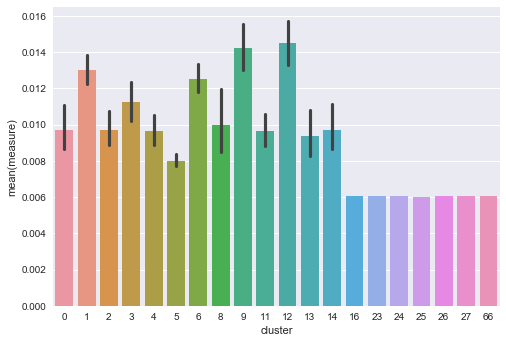

In [30]:
idx = authors['Cluster'] != 'No Group'
idx2 = centrality['cluster'].isin(authors['Cluster'].value_counts().index[0:21].values)


sns.barplot(x = centrality.ix[idx2,'cluster'], y = centrality.ix[idx2,'measure'], orient = 'v')

In [16]:
authors['Cluster'] = authors['name'].map(parts)
authors['Cluster'] = authors['Cluster'].fillna('No Group')
idx = authors['Cluster'] != 'No Group'
authors.ix[idx,'Cluster'] = authors.ix[idx,'Cluster'].astype(int)



In [17]:
raw_posts['Cluster'] = raw_posts['author'].map(parts)
raw_posts_small = raw_posts[raw_posts['Cluster'].isin(authors['Cluster'].value_counts().index[0:21].values)]

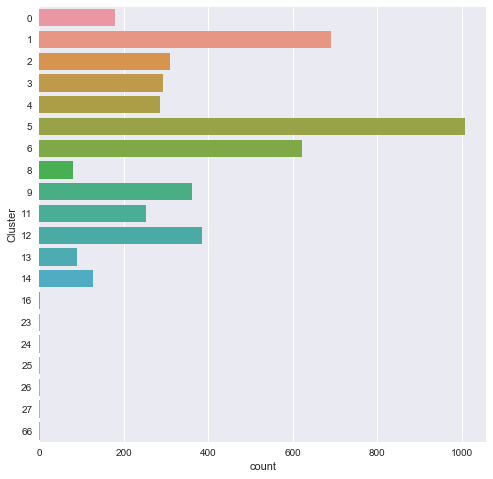

In [18]:
fig,ax = plt.subplots(1,1,figsize = (8,8))
idx = authors['Cluster'] != 'No Group'
idx2 = authors['Cluster'].isin(authors['Cluster'].value_counts().index[0:21].values)

sns.countplot(y = authors.ix[idx&idx2,'Cluster'], ax =ax)

In [31]:
top_20_authors

NameError: name 'top_20_authors' is not defined

In [32]:
grouped = raw_posts.groupby('Cluster').sum().reset_index()
raw_posts['count'] = 1
grouped_count = raw_posts.groupby('Cluster').count().reset_index()

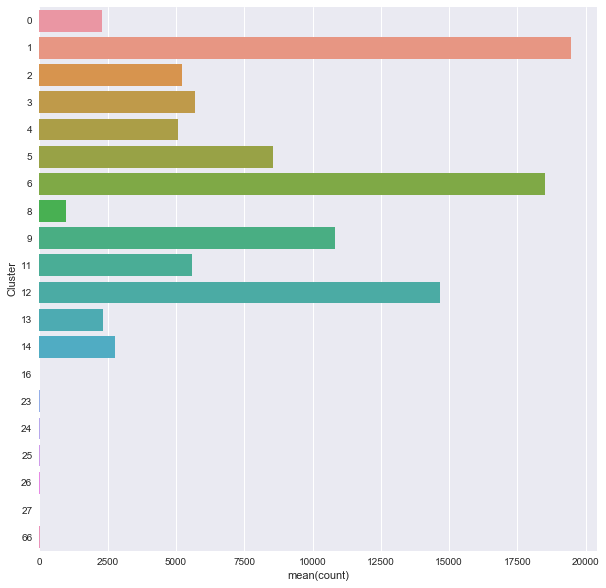

In [35]:
idx = raw_posts['Cluster'].isin(top_20_clusters)
raw_posts_plot = raw_posts[idx]

idx = grouped_count['Cluster'].isin(top_20_clusters)
bar_plot_data = grouped_count.ix[idx,['Cluster','count']]
bar_plot_data['Cluster'] = bar_plot_data['Cluster'].astype(int)
fig,ax = plt.subplots(1,1,figsize = (10,10))

sns.barplot(x = 'count',y = 'Cluster',data=bar_plot_data, orient='h',ax = ax)

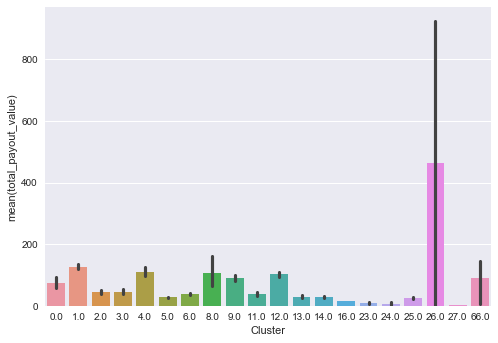

In [34]:
idx = authors['Cluster'] != 'No Group'
top_20_clusters = authors['Cluster'].value_counts().index[0:21].values
idx = raw_posts['Cluster'].isin(top_20_clusters)
raw_posts_plot = raw_posts[idx]
sns.barplot(x = 'Cluster',y = 'total_payout_value',
            data = raw_posts_plot)
            # plt.savefig('bar_chart.png')

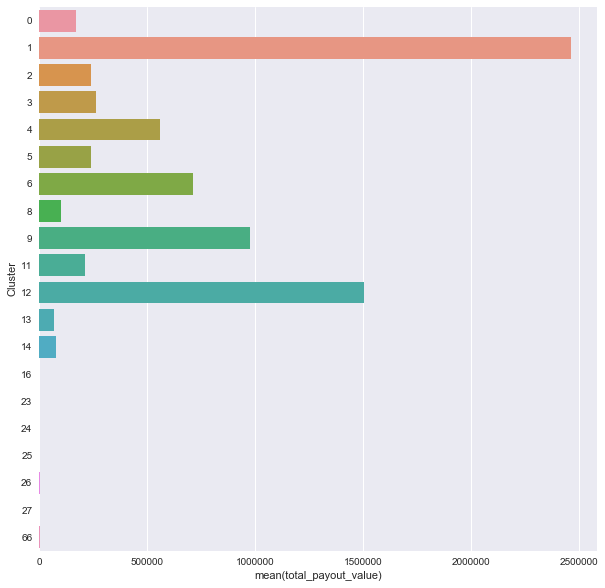

In [36]:
idx = raw_posts['Cluster'].isin(top_20_clusters)
raw_posts_plot = raw_posts[idx]

idx = grouped['Cluster'].isin(top_20_clusters)
bar_plot_data = grouped.ix[idx,['Cluster','total_payout_value']]
bar_plot_data['Cluster'] = bar_plot_data['Cluster'].astype(int)
fig,ax = plt.subplots(1,1,figsize = (10,10))

sns.barplot(x = 'total_payout_value',y = 'Cluster',data=bar_plot_data, orient='h',ax = ax)

In [ ]:
idx = authors['Cluster'] != 'No Group'
top_20_clusters = authors['Cluster'].value_counts().index[0:21].values
idx = raw_posts['Cluster'].isin(top_20_clusters)
raw_posts_plot = raw_posts[idx]
sns.barplot(x = 'Cluster',y = 'total_payout_value',
            data = raw_posts_plot)
            # plt.savefig('bar_chart.png')

In [ ]:
idx = authors['Cluster'] != 'No Group'
top_20_clusters = authors['Cluster'].value_counts().index[0:21].values
idx = raw_posts['Cluster'].isin(top_20_clusters)
raw_posts_plot = raw_posts[idx]
sns.barplot(x = 'Cluster',y = 'number of body tags',
            data = raw_posts_plot)
            # plt.savefig('bar_chart.png')
    
plt.title('Cluster with Average Number of Body Tags')

In [ ]:
idx = authors['Cluster'] != 'No Group'
top_20_clusters = authors['Cluster'].value_counts().index[0:21].values
idx = raw_posts['Cluster'].isin(top_20_clusters)
raw_posts_plot = raw_posts[idx]
sns.barplot(x = 'Cluster',y = 'number of body urls',
            data = raw_posts_plot)
            # plt.savefig('bar_chart.png')
    
plt.title('Cluster with Average Number of Body URls')

In [ ]:
idx = authors['Cluster'] != 'No Group'
top_20_clusters = authors['Cluster'].value_counts().index[0:21].values
idx = raw_posts['Cluster'].isin(top_20_clusters)
raw_posts_plot = raw_posts[idx]
sns.barplot(x = 'Cluster',y = 'number of youtube urls',
            data = raw_posts_plot)
            # plt.savefig('bar_chart.png')
    
plt.title('Cluster with Average Number of Video URls')

In [ ]:
idx = authors['Cluster'] != 'No Group'
top_20_clusters = authors['Cluster'].value_counts().index[0:21].values
idx = raw_posts['Cluster'].isin(top_20_clusters)
raw_posts_plot = raw_posts[idx]
sns.barplot(x = 'Cluster',y = 'number of body tags',
            data = raw_posts_plot)
            # plt.savefig('bar_chart.png')
    
plt.title('Cluster with Average Number of Body Tags')

In [ ]:
idx = authors['Cluster'] != 'No Group'
top_20_clusters = authors['Cluster'].value_counts().index[0:21].values
idx = raw_posts['Cluster'].isin(top_20_clusters)
raw_posts_plot = raw_posts[idx]
sns.barplot(x = 'reward_weight',y = 'curator_payout_value',
            data = raw_posts_plot)
            # plt.savefig('bar_chart.png')
    
plt.title('Cluster with Average Number of Body Tags')

In [ ]:
raw_posts_plot.head().columns

In [ ]:
raw_posts['reward_weight']